In [1]:
# define network parameters
max_features = 20000
maxlen = 100

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import Conv1D, GlobalMaxPool1D, Dropout, concatenate
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output

/home/yamazaki/third_party/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
train = pd.read_csv("input/train.csv")
list_sentences_train = train["comment_text"].fillna("Invalid").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [5]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
# train data
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)

In [6]:
def build_model(conv_layers = 2, max_dilation_rate = 4):
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Dropout(0.25)(x)
    x = Conv1D(2*embed_size, 
                   kernel_size = 3)(x)
    prefilt_x = Conv1D(2*embed_size, 
                   kernel_size = 3)(x)
    out_conv = []
    # dilation rate lets us use ngrams and skip grams to process 
    for dilation_rate in range(max_dilation_rate):
        x = prefilt_x
        for i in range(3):
            x = Conv1D(32*2**(i), 
                       kernel_size = 3, 
                       dilation_rate = 2**dilation_rate)(x)    
        out_conv += [Dropout(0.5)(GlobalMaxPool1D()(x))]
    x = concatenate(out_conv, axis = -1)    
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy'])

    return model

model = build_model()

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 128)     2560000     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100, 128)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 256)      98560       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [8]:
batch_size = 512
epochs = 15

file_path="weights.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

callbacks_list = [checkpoint, early] #early
model.fit(X_t, y, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.1, 
          callbacks=callbacks_list)
model.load_weights(file_path)
clear_output()

In [9]:
eval_results = model.evaluate(X_t, y, batch_size=batch_size)
for c_name, c_val in zip(model.metrics_names, eval_results):
    print(c_name, '%2.3f' % (c_val))

159571/159571 [==============================] - 368s 2ms/step
loss 0.042
binary_accuracy 0.984


In [12]:
from glob import glob
import os
import dask.dataframe as ddf
rustweet_dir = os.path.join('input', 'russian-troll-tweets')
all_tweets_ddf = ddf.read_csv(os.path.join(rustweet_dir, '*.csv'), assume_missing=True)
english_tweets_ddf = all_tweets_ddf[all_tweets_ddf['language'].isin(['English'])]
content_cat_ddf = english_tweets_ddf[['content', 'account_category']]
all_tweets_ddf

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
npartitions=17,,,,,,,,,,,,,,,
,float64,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
%%time
content_cat_df = content_cat_ddf.sample(frac=0.2).compute().drop_duplicates()
print(content_cat_df.shape[0], 'tweets loaded')

/home/yamazaki/third_party/anaconda3/envs/tensorflow/lib/python3.5/site-packages/dask/local.py:290: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


397565 tweets loaded
CPU times: user 34.4 s, sys: 5.4 s, total: 39.8 s
Wall time: 27 s


,content,account_category
221201,#TopNews Family of man shot by Cincinnati univ...,NewsFeed
223495,We raised more money quicker than any local ca...,LeftTroll
86038,"Asking honestly here, is chanting ""USA!"" now c...",RightTroll


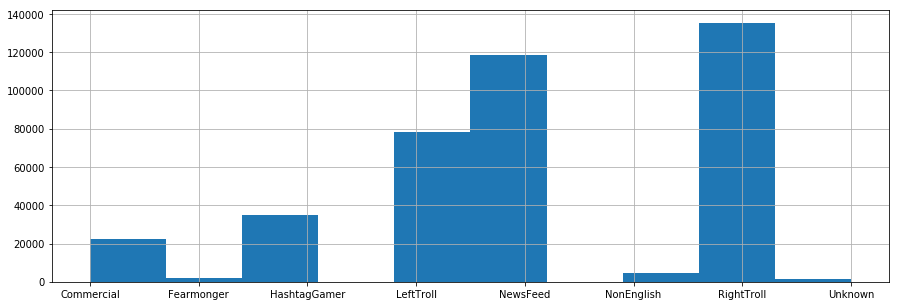

In [14]:
fig, ax1 = plt.subplots(1,1, figsize = (15, 5))
content_cat_df['account_category'].hist(ax=ax1)
content_cat_df.sample(3)

In [15]:
# test data
list_tweets = content_cat_df["content"].fillna("Invalid").values
list_tokenized_tweets = tokenizer.texts_to_sequences(list_tweets)
X_twe = sequence.pad_sequences(list_tokenized_tweets, maxlen=maxlen)

In [16]:
# run the model on all data
y_twe = model.predict(X_twe, batch_size=1024, verbose=True)

397565/397565 [==============================] - 932s 2ms/step


In [17]:
toxicity_df = pd.DataFrame(y_twe, columns = list_classes)
toxicity_df['content_category'] = content_cat_df['account_category'].values.copy()
toxicity_df['total_hatefulness'] = np.sum(y_twe, 1)

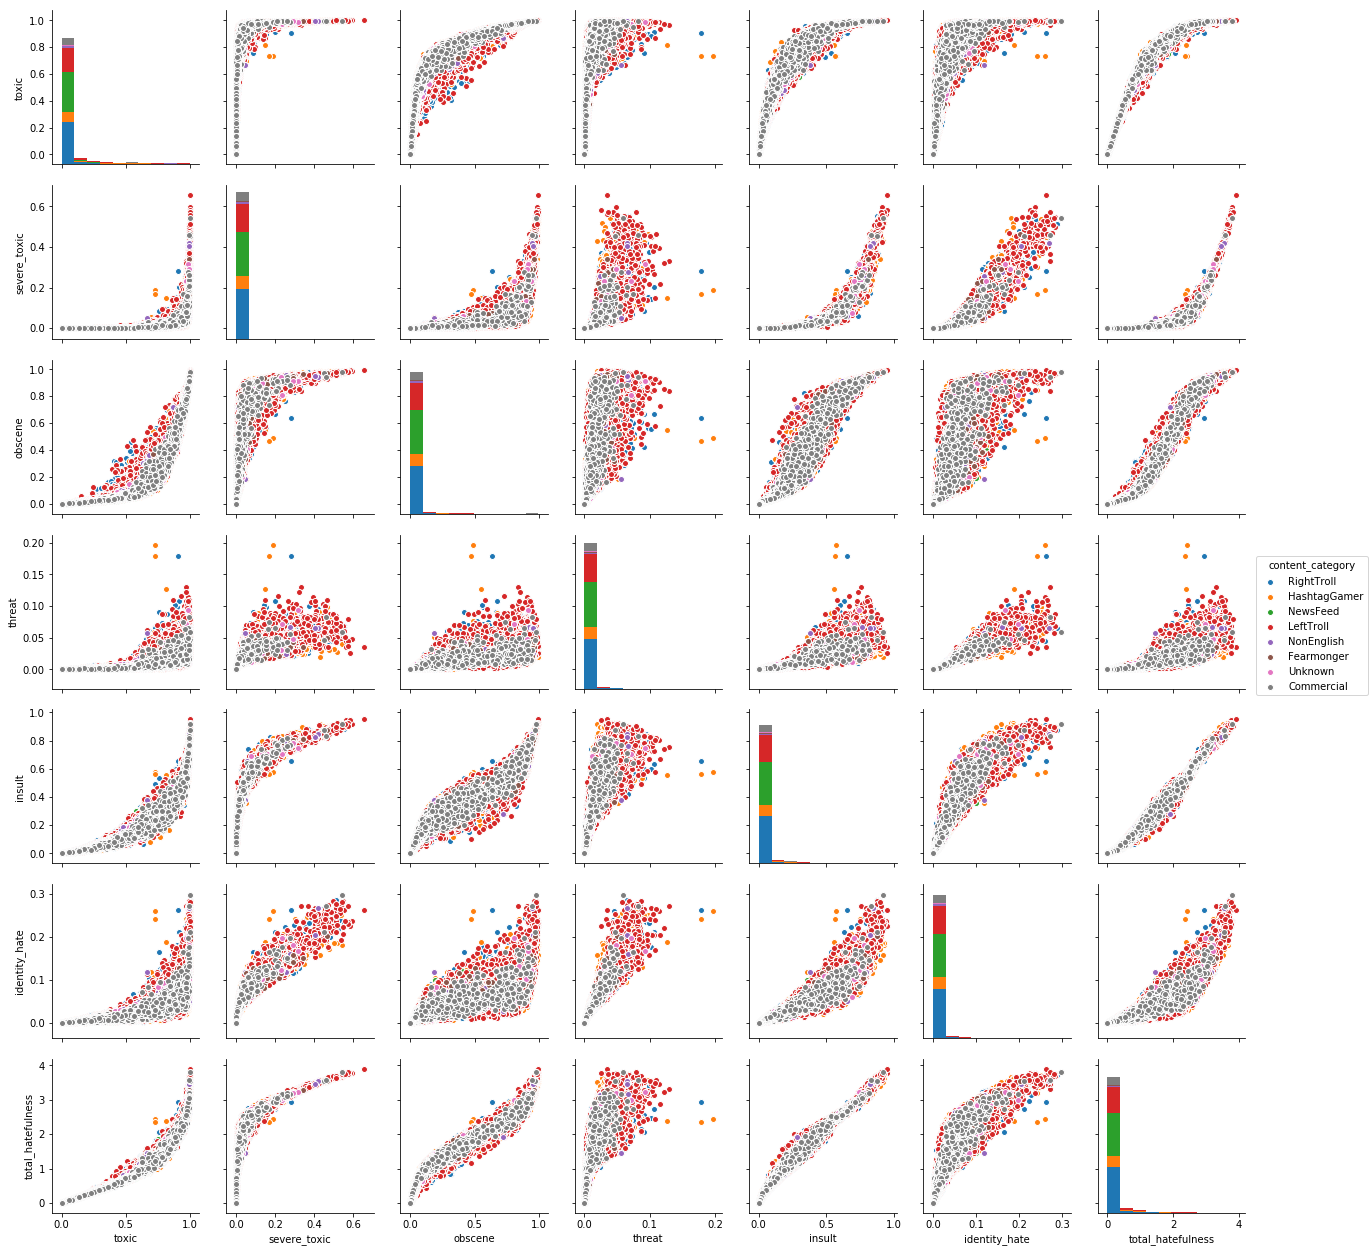

In [18]:
sns.pairplot(toxicity_df, hue = 'content_category')

In [19]:
from IPython.display import Markdown, display
display_markdown = lambda x: display(Markdown(x))
def show_sentence(sent_idx):
    display_markdown('# Input Sentence:\n `{}`'.format(list_tweets[sent_idx]))
    c_pred = model.predict(X_twe[sent_idx:sent_idx+1])[0]
    display_markdown('## Scores')
    for k, p in zip(list_classes, c_pred):
        display_markdown('- {}, Prediction: {:2.2f}%'.format(k, 100*p))
show_sentence(50)

# Input Sentence:
 `Yes We Can Yes We Did.Thank you @POTUS @FLOTUS n family for the last 8 yrs.U gave us hope in so many ways,never giving up. #ObamaFarewell https://t.co/9Eab4eiJsm`

## Scores

- toxic, Prediction: 9.93%

- severe_toxic, Prediction: 0.02%

- obscene, Prediction: 1.32%

- threat, Prediction: 0.03%

- insult, Prediction: 1.70%

- identity_hate, Prediction: 0.27%

In [20]:
worst_tweets = np.argsort(-1*toxicity_df['total_hatefulness'].values)
for _, idx in zip(range(5), 
                  worst_tweets):
    show_sentence(idx)

# Input Sentence:
 `Now you know this is the truth! Fuck ppl who "joke" about killing trans women FUCK THEM FUCK THOSE FUCKING ASSHOLES https://t.co/P4lZunWKRA`

## Scores

- toxic, Prediction: 99.99%

- severe_toxic, Prediction: 65.57%

- obscene, Prediction: 99.48%

- threat, Prediction: 3.51%

- insult, Prediction: 95.02%

- identity_hate, Prediction: 26.35%

# Input Sentence:
 `I saw this with so much love in my heart- fuck you. Fuck you niggas and fuck being nice, I'm done taking your shit and your projection.`

## Scores

- toxic, Prediction: 99.89%

- severe_toxic, Prediction: 57.24%

- obscene, Prediction: 97.98%

- threat, Prediction: 7.88%

- insult, Prediction: 90.62%

- identity_hate, Prediction: 27.15%

# Input Sentence:
 `Gtfo with your hating ass chunti mf ass wipe fat bitch I can loose the weight but your staying ugly dumb bitch @CoffeeCupAA @groovy_za`

## Scores

- toxic, Prediction: 99.91%

- severe_toxic, Prediction: 54.43%

- obscene, Prediction: 97.82%

- threat, Prediction: 5.90%

- insult, Prediction: 91.97%

- identity_hate, Prediction: 29.80%

# Input Sentence:
 `Piece of shit with a gun. Fuck that fucking pig! https://t.co/yzS6p1MClH`

## Scores

- toxic, Prediction: 99.96%

- severe_toxic, Prediction: 59.58%

- obscene, Prediction: 98.62%

- threat, Prediction: 4.85%

- insult, Prediction: 91.54%

- identity_hate, Prediction: 23.74%

# Input Sentence:
 `Once again FUCK FUCK FUVK FUCK the police https://t.co/eua1SiIM7x`

## Scores

- toxic, Prediction: 99.99%

- severe_toxic, Prediction: 58.16%

- obscene, Prediction: 99.33%

- threat, Prediction: 2.58%

- insult, Prediction: 94.85%

- identity_hate, Prediction: 22.63%

In [21]:
toxicity_df.groupby('content_category').agg(lambda x: round(100*np.mean(x))).reset_index().sort_values('total_hatefulness', ascending=False)

,content_category,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_hatefulness
2,HashtagGamer,12.0,0.0,4.0,0.0,4.0,1.0,22.0
1,Fearmonger,12.0,0.0,4.0,0.0,4.0,1.0,21.0
3,LeftTroll,9.0,0.0,3.0,0.0,3.0,1.0,17.0
7,Unknown,9.0,0.0,2.0,0.0,3.0,1.0,15.0
6,RightTroll,7.0,0.0,2.0,0.0,2.0,0.0,12.0
0,Commercial,6.0,0.0,2.0,0.0,2.0,0.0,10.0
5,NonEnglish,4.0,0.0,1.0,0.0,1.0,0.0,7.0
4,NewsFeed,3.0,0.0,0.0,0.0,1.0,0.0,5.0


In [22]:
toxicity_df.groupby('content_category').agg(lambda x: round(100*np.max(x))).reset_index().sort_values('total_hatefulness', ascending=False)

,content_category,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_hatefulness
3,LeftTroll,100.0,66.0,99.0,13.0,95.0,28.0,390.0
0,Commercial,100.0,54.0,98.0,8.0,92.0,30.0,380.0
6,RightTroll,100.0,55.0,99.0,18.0,92.0,29.0,374.0
2,HashtagGamer,100.0,54.0,99.0,20.0,93.0,26.0,371.0
1,Fearmonger,100.0,46.0,97.0,5.0,88.0,20.0,356.0
5,NonEnglish,100.0,42.0,95.0,7.0,85.0,27.0,354.0
7,Unknown,99.0,32.0,94.0,9.0,78.0,20.0,322.0
4,NewsFeed,98.0,15.0,88.0,6.0,65.0,13.0,270.0


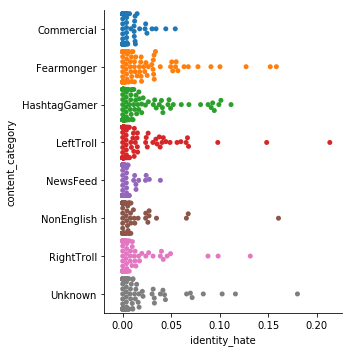

In [23]:
cat_sample_df = toxicity_df.groupby('content_category').apply(lambda x: x.sample(250, replace=False if x.shape[0]>1000 else True)).reset_index(drop=True)
sns.factorplot(y='content_category', x='identity_hate', kind='swarm', data=cat_sample_df, size=5)

In [24]:
# rescale the axes a bit
clip_tox_df = toxicity_df.copy()
for c_class in list_classes:
    clip_tox_df[c_class] = np.sqrt(np.clip(clip_tox_df[c_class], 0, .025))

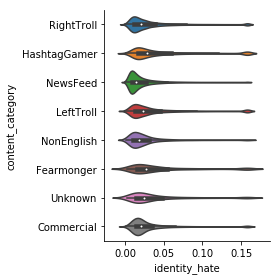

In [25]:
sns.factorplot(y='content_category', x='identity_hate', kind='violin', data=clip_tox_df)

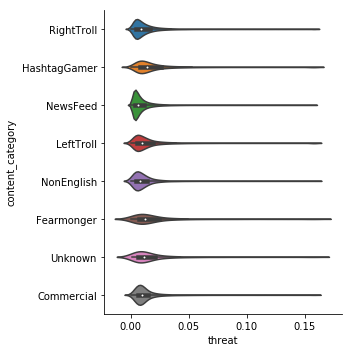

In [26]:
sns.factorplot(y='content_category', x='threat', kind='violin', data=clip_tox_df, size=5)

In [27]:
from sklearn.model_selection import train_test_split
tx_train_df, tx_valid_df = train_test_split(toxicity_df, 
                                            test_size = 0.25,
                                            random_state = 2018,
                                            stratify=toxicity_df['content_category'])

25.55% accuracy
              precision    recall  f1-score   support

  Commercial       0.06      0.06      0.06      5682
  Fearmonger       0.01      0.01      0.01       493
HashtagGamer       0.08      0.08      0.08      8490
   LeftTroll       0.19      0.19      0.19     19557
    NewsFeed       0.30      0.30      0.30     29625
  NonEnglish       0.02      0.02      0.02      1200
  RightTroll       0.34      0.34      0.34     33931
     Unknown       0.01      0.00      0.01       414

 avg / total       0.26      0.26      0.26     99392



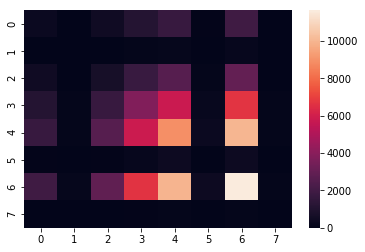

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
dmc = DummyClassifier()
def fit_and_show(in_skl_model):
    in_skl_model.fit(tx_train_df[list_classes], tx_train_df['content_category'])
    out_pred = in_skl_model.predict(tx_valid_df[list_classes])
    print('%2.2f%%' % (100*accuracy_score(out_pred, tx_valid_df['content_category'])), 'accuracy')
    print(classification_report(out_pred, tx_valid_df['content_category']))
    sns.heatmap(confusion_matrix(tx_valid_df['content_category'], out_pred))
fit_and_show(dmc)

34.26% accuracy


/home/yamazaki/third_party/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

  Commercial       0.00      0.00      0.00         0
  Fearmonger       0.00      0.00      0.00         0
HashtagGamer       0.00      0.00      0.00         0
   LeftTroll       0.03      0.44      0.05      1310
    NewsFeed       0.00      0.00      0.00         0
  NonEnglish       0.00      0.00      0.00         0
  RightTroll       0.99      0.34      0.51     98082
     Unknown       0.00      0.00      0.00         0

 avg / total       0.98      0.34      0.50     99392



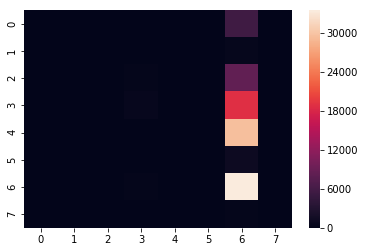

In [29]:
from sklearn.linear_model import LogisticRegression
lrm = LogisticRegression()
fit_and_show(lrm)

41.57% accuracy
              precision    recall  f1-score   support

  Commercial       0.20      0.27      0.23      4041
  Fearmonger       0.12      0.31      0.18       197
HashtagGamer       0.27      0.33      0.30      7129
   LeftTroll       0.27      0.29      0.28     17824
    NewsFeed       0.54      0.45      0.49     35546
  NonEnglish       0.06      0.46      0.11       164
  RightTroll       0.48      0.48      0.48     34388
     Unknown       0.01      0.04      0.02       103

 avg / total       0.44      0.42      0.42     99392



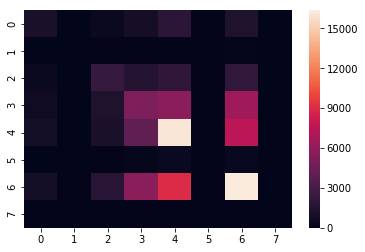

In [30]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
fit_and_show(rfc)